In [9]:
import os
import sys
parent = os.path.abspath(os.path.join('./', os.pardir))
sys.path.insert(0, parent) # Add parent dirrectory to temporary path for imports
fontPath = os.path.abspath(os.path.join(parent,'UKNumberPlate.ttf'))

from nbp_helper_funs import *
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)

## Explanation

It currently takes a lot of time to generate the randomly distorted plate images for the bots to compete against. We thought that we could speed this up by using some of the code we've write anyway. Here figured out how to simulate the rotation of a 2D image in 3D space using [homogenous coordinates](https://kogs-www.informatik.uni-hamburg.de/~neumann/BV-WS-2007/BV-3-07.pdf) of the 4 corners of the image. The perspective is achieved by moving the image away from the camera by the `f = max(width,height)` (which, in his cace amounts to the image's width) and projection the image onto the focal plane which is also `f` far away from camera. Thous could be adjusted in the future, but it seamed to give good results for a time being.

Note that the processing of the point coordinates is done with numpy whos' point convention is (height, width), but the final and initial lists of points (`P1` and `P2`) are written as (width, height) to adhere to numpy convention.

The function uses the same transform function (PIL's `im.transform` and `getTransformCoeffs`) used in the main bot.

The running time of the meat of this transform is around 1ms.

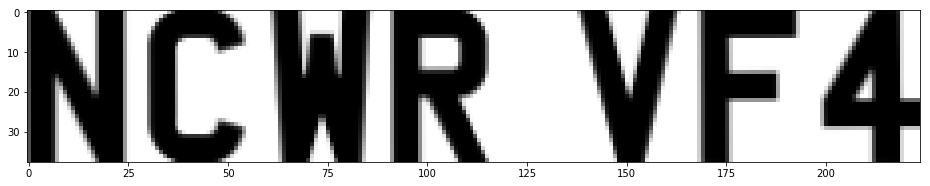

In [10]:
height =  int(60*45/71)
plate = pil2np(randomPlateImage(height, fontPath=fontPath))

h,w = plate.shape
f = max(w,h) # Focal plane distance
plt.imshow(plate, cmap='gray')
plt.show()

In [31]:
P1 = [(0,0),(w,0),(w,h),(0,h)] # Image points in (width, height) pairs

# A bunch of transformation functions
def n2h(N, w=1):
    ''' Transform to Homogenous image coordinates '''
    return np.array(list(list(w*x for x in n) + [w,] for n in N.T)).T

def h2n(H):
    ''' Transfrom back to Normal image coordiantes '''
    return np.array(list(h[:-1]/h[-1] for h in H.T)).T

def p2n(P):
    ''' Transfrom from image points to Normal coordinates '''
    return np.array(list([p[1], p[0], 0] for p in P)).T

def n2p(N):
    ''' Transform from Normal coordinates to image points '''
    return list(( (c[1], c[0]) for c in N.T))

H = n2h(N) # Homogenous coordinates of the initial image corners

print('Image point coordinates:')
print(P1)
print('\n' + 'Nomral coordinates:')
print(p2n(P1))
print('\n' + 'Homogenous coordinates:')
print(H)

Image point coordinates:
[(0, 0), (224, 0), (224, 38), (0, 38)]

Nomral coordinates:
[[  0   0  38  38]
 [  0 224 224   0]
 [  0   0   0   0]]

Homogenous coordinates:
[[  0   0  38  38]
 [  0 224 224   0]
 [  0   0   0   0]
 [  1   1   1   1]]


In [29]:
i = lambda M: np.linalg.inv(M) # Shortcut for inverses (not actually used)

# Translations in Normal coordinates
def xyCenterN(N):
    ''' Shift N to be centered around the origin in the xy plane '''
    return np.array(list(r - np.mean(r) for r in N[:-1]) + [N[-1],])

def xyZeroN(N):
    ''' Sift N to have top left corner of the image at the origin in the xy plane '''
    return np.array(list(r - np.min(r) for r in N[:-1]) + [N[-1],])

In [32]:
%%time
# Image transfomrations in homogenous coordinates

angles = [0, -np.pi/8, np.pi/4] # alpha, beta, gamma angles of rotation (in radians)

c = list(np.cos(angle) for angle in angles)
s = list(np.sin(angle) for angle in angles)

# Three rotation matrices for three planes
R1 = np.array([[ c[0] , -s[0] ,  0    ,  0   ],
               [ s[0] ,  c[0] ,  0    ,  0   ],
               [ 0    ,  0    ,  1    ,  0   ],
               [ 0    ,  0    ,  0    ,  1   ]])

R2 = np.array([[ c[1] ,  0    , -s[1] ,  0   ],
               [ 0    ,  1    ,  0    ,  0   ],
               [ s[1] ,  0    ,  c[1] ,  0   ],
               [ 0    ,  0    ,  0    ,  1   ]])

R3 = np.array([[ 1    ,  0    ,  0    ,  0   ],
               [ 0    ,  c[2] , -s[2] ,  0   ],
               [ 0    ,  s[2] ,  c[2] ,  0   ],
               [ 0    ,  0    ,  0    ,  1   ]])

# Translation to center coordinates
Tc  = np.array([[ 1    ,  0    ,  0    , -h/2 ],
                [ 0    ,  1    ,  0    , -w/2 ],
                [ 0    ,  0    ,  1    ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

# Translation to the focal plane
Tf  = np.array([[ 1    ,  0    ,  0    ,  0   ],
                [ 0    ,  1    ,  0    ,  0   ],
                [ 0    ,  0    ,  1    ,  f   ],
                [ 0    ,  0    ,  0    ,  1   ]])

# Orhographic projection matrix (for completness)
oP  = np.array([[ 1    ,  0    ,  0    ,  0   ],
                [ 0    ,  1    ,  0    ,  0   ],
                [ 0    ,  0    ,  1    ,  0   ],
                [ 0    ,  0    ,  0    ,  1   ]])

# Perspective projection matrix
pP  = np.array([[ 1    ,  0    ,  0    ,  0   ],
                [ 0    ,  1    ,  0    ,  0   ],
                [ 0    ,  0    ,  1    ,  0   ],
                [ 0    ,  0    ,  1/f  ,  0   ]])

# Move origin to center of the image, apply R1, R2 and R3, translate back and finally project
R = R3@R2@R1

CPU times: user 112 µs, sys: 1e+03 ns, total: 113 µs
Wall time: 118 µs


In [33]:
%%time
# Without rotation
H1 = pP @ Tf @ Tc @ H
N1 = h2n(H1)
N1 = xyZeroN(N1)
P1 = n2p(N1)

# With rotation
H2 = pP @ Tf @ R  @ Tc @ H
N2 = h2n(H2)
N2 = xyZeroN(N2)
P2 = n2p(N2)

print(P1)
print(P2)

[(0.0, 0.0), (224.0, 0.0), (224.0, 38.0), (0.0, 38.0)]
[(0.0, 0.0), (179.78855977379169, 13.47071760573901), (189.37247719437948, 39.415405445344142), (7.2160592730241717, 54.376859319093938)]
CPU times: user 735 µs, sys: 869 µs, total: 1.6 ms
Wall time: 819 µs


(0.0, 0.0) -> (0.0, 0.0)
(224.0, 0.0) -> (179.78855977379169, 13.47071760573901)
(224.0, 38.0) -> (189.37247719437948, 39.415405445344142)
(0.0, 38.0) -> (7.2160592730241717, 54.376859319093938)


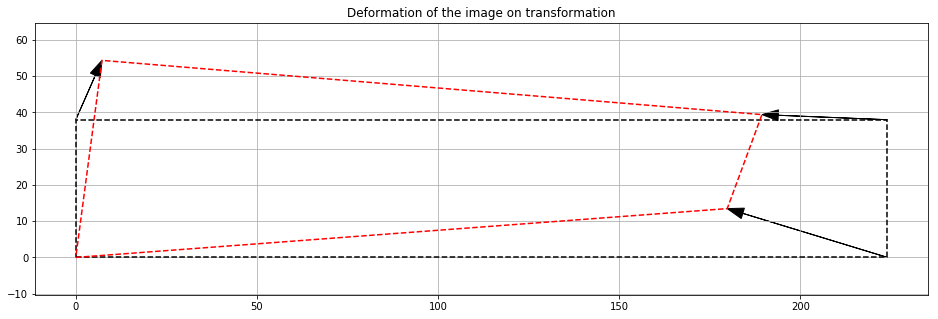

In [34]:
P1p = list(zip(*(P1 + [P1[0],])))
P2p = list(zip(*(P2 + [P2[0],])))
plt.plot(P1p[0],P1p[1],'k--')
plt.plot(P2p[0],P2p[1],'r--')
for p,pt in zip(P1,P2):
    print(p, '->' ,pt)
    if p != pt: plt.arrow(p[0],p[1],pt[0]-p[0],pt[1]-p[1],
                          head_width=3, length_includes_head=True, color='black')
plt.axis('equal')
plt.title('Deformation of the image on transformation')
plt.grid()
plt.show()

In [20]:
def P2wh(P):
    ''' Figure out the width and height of the final image from points '''
    return tuple(int(x) for x in np.ceil(np.max(list(zip(*P2)),axis=1)))

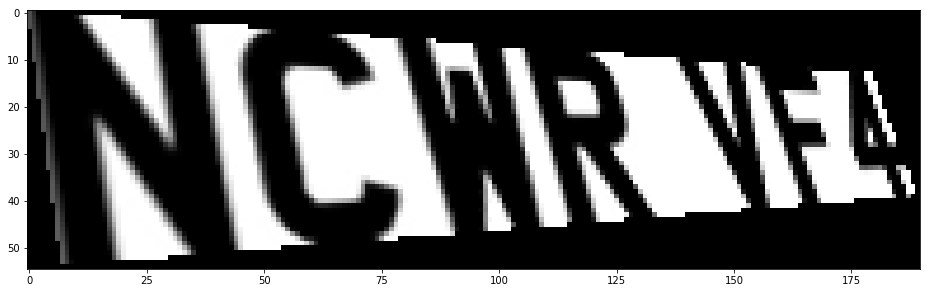

CPU times: user 385 ms, sys: 48 ms, total: 433 ms
Wall time: 223 ms


In [35]:
%%time
im = np2pil(plate)
coeffs = getTransformCoeffs(P1,P2)
im = im.transform(P2wh(P2), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

plt.rcParams["figure.figsize"] = (16,5)
plt.imshow(pil2np(im), cmap='gray')
plt.show()